# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import Transfer, mape, rmse

# Loading datasets

In [2]:
# French data
train = pd.read_csv('data/train.csv')
test1 = pd.read_csv('data/test1.csv')
test2 = pd.read_csv('data/test2.csv')
test3 = pd.read_csv('data/test3.csv')

# Italian data
train_it = pd.read_csv('data/train_it.csv')
test1_it = pd.read_csv('data/test1_it.csv')
test2_it = pd.read_csv('data/test2_it.csv')

In [3]:
train_it_2018 = train_it.query("DateH >='2018-01-01 02:00:00' and DateH <='2019-01-01 01:00:00'")
train_fr_2018 = train.query("DateH >='2018-01-01 02:00:00' and DateH <='2019-01-01 01:00:00'")
rho = train_fr_2018["Consommation"].sum()/train_it_2018["Consommation"].sum()
rho

1.566428876297778

# Loading experts

### Forecasts

In [51]:
# French data
gamtrain = pd.read_csv('data/experts/gamtrain_forecast.csv')['x']
gam1_v2 = pd.read_csv('data/experts/gam1_forecast_v2.csv')['x']
gam2_v2 = pd.read_csv('data/experts/gam2_forecast_v2.csv')['x']

gams1_v2 = pd.read_csv('data/experts/gams1_forecast_v2.csv')['x']
gams2_v2 = pd.read_csv('data/experts/gams2_forecast_v2.csv')['x']

gbm1_v2 = pd.read_csv('data/experts/gbm1_forecast_v2.csv')['x']
gbm2_v2 = pd.read_csv('data/experts/gbm2_forecast_v2.csv')['x']

# Aggregation of experts
exp1_v2 = pd.read_csv('data/experts/X1_agg_v2.csv')['X1_agg']
exp2_v2 = pd.read_csv('data/experts/X2_agg_v2.csv')['X2_agg']

# Italian data
gamittrain_v2 = pd.read_csv('data/experts/gamit_forecast_v2.csv')['x']
gam1_it_v2 = pd.read_csv('data/experts/gam1it_forecast_v2.csv')['x']
gam2_it_v2 = pd.read_csv('data/experts/gam2it_forecast_v2.csv')['x']
gbm1_it_v2 = pd.read_csv('data/experts/gbm1it_forecast_v2.csv')['x']
gbm2_it_v2 = pd.read_csv('data/experts/gbm2it_forecast_v2.csv')['x']


### Spline

In [12]:
# French data
basis_v2 = pd.read_csv('data/experts/basis_france_v2.csv', index_col=0)
basis1_v2 = pd.read_csv('data/experts/basis1_france_v2.csv', index_col=0)
basis2_v2 = pd.read_csv('data/experts/basis2_france_v2.csv', index_col=0)
betas_v2 = pd.read_csv('data/experts/betas_france_v2.csv', index_col=0)

# Italian data
basis_it_v2 = pd.read_csv('data/experts/basis_it_v2.csv', index_col=0)
basis1_it_v2 = pd.read_csv('data/experts/basis1_it_v2.csv', index_col=0)
basis2_it_v2 = pd.read_csv('data/experts/basis2_it_v2.csv', index_col=0)
betas_it_v2 = pd.read_csv('data/experts/betas_italy_v2.csv', index_col=0)


# Transfer learning

### Test 1

In [18]:
tr_te1_v2 = Transfer(betas_v2, betas_it_v2, basis1_v2, basis1_it_v2, test1['Consommation'], test1_it['Consommation'], K=75, rho=rho)
ft_te1_v2 = tr_te1_v2.gam_ft()
delta1_v2 = tr_te1_v2.gam_delta()

100%|██████████| 1488/1488 [00:29<00:00, 50.19it/s]


In [22]:
ft_delta1_v2 = tr_te1_v2.gam_delta_ft()

100%|██████████| 1488/1488 [01:06<00:00, 22.39it/s]


### Test 2

In [14]:
tr_te2_v2 = Transfer(betas_v2, betas_it_v2, basis2_v2, basis2_it_v2, test2['Consommation'], test2_it['Consommation'], K=75,rho=rho)
ft_te2_v2 = tr_te2_v2.gam_ft()
delta2_v2 = tr_te2_v2.gam_delta()

100%|██████████| 2544/2544 [00:58<00:00, 43.33it/s]


In [25]:
ft_delta2_v2 = tr_te2_v2.gam_delta_ft()

100%|██████████| 2544/2544 [02:11<00:00, 19.39it/s]


# Plotting the results

In [49]:
print('MAPE GAM      : ', mape(test1['Consommation'], gam1_v2), '; RMSE GAM      : ', rmse(test1['Consommation'], gam1_v2))
print('MAPE GBM      : ', mape(test1['Consommation'], gbm1_v2), '; RMSE GBM      : ', rmse(test1['Consommation'], gbm1_v2))
print('MAPE GAM_ft   : ', mape(test1['Consommation'], ft_te1_v2), ' ; RMSE GAM_ft   : ', rmse(test1['Consommation'], ft_te1_v2))
print('MAPE GAM_dt   : ', mape(test1['Consommation'], delta1_v2), ' ; RMSE GAM_dt   : ', rmse(test1['Consommation'], delta1_v2))
print('MAPE GAM_dt_ft: ', mape(test1['Consommation'], ft_delta1_v2))
print('MAPE GAM_sat  : ', mape(test1['Consommation'], gams1_v2), '; RMSE GAM      : ', rmse(test1['Consommation'], gams1_v2))
print('MAPE AGG      : ', mape(test1['Consommation'], exp1_v2), '; RMSE AGG      : ', rmse(test1['Consommation'], exp1_v2))

print()

print('MAPE GAM      : ', mape(test2['Consommation'], gam2_v2), '; RMSE GAM      : ', rmse(test2['Consommation'], gam2_v2))
print('MAPE GBM      : ', mape(test2['Consommation'], gbm2_v2), '; RMSE GBM      : ', rmse(test2['Consommation'], gbm2_v2))
print('MAPE GAM_ft   : ', mape(test2['Consommation'], ft_te2_v2), '; RMSE GAM_ft   : ', rmse(test2['Consommation'], ft_te2_v2))
print('MAPE GAM_dt   : ', mape(test2['Consommation'], delta2_v2), '; RMSE GAM_dt   : ', rmse(test2['Consommation'], delta2_v2))
print('MAPE GAM_dt_ft: ', mape(test2['Consommation'], ft_delta2_v2))
print('MAPE GAM_sat  : ', mape(test2['Consommation'], gams2_v2), '; RMSE GAM      : ', rmse(test2['Consommation'], gams2_v2))
print('MAPE AGG      : ', mape(test2['Consommation'], exp2_v2), '; RMSE AGG      : ', rmse(test2['Consommation'], exp2_v2))


MAPE GAM      :  5.401041241401003 ; RMSE GAM      :  3076.3954023280658
MAPE GBM      :  6.338548430350978 ; RMSE GBM      :  3482.6185698146946
MAPE GAM_ft   :  3.9559865921970907  ; RMSE GAM_ft   :  2417.4448293864807
MAPE GAM_dt   :  10.957041286443342  ; RMSE GAM_dt   :  6063.044914739409
MAPE GAM_dt_ft:  3.7825222097192953e+39
MAPE GAM_sat  :  4.017886294182259 ; RMSE GAM      :  2519.6132611089442
MAPE AGG      :  2.6398606502479534 ; RMSE AGG      :  1553.2363636169496

MAPE GAM      :  3.766759910455933 ; RMSE GAM      :  2030.2059897335505
MAPE GBM      :  5.042647687727022 ; RMSE GBM      :  2606.8977835794162
MAPE GAM_ft   :  3.784551257105156 ; RMSE GAM_ft   :  2024.1193754500546
MAPE GAM_dt   :  4.402121107816272 ; RMSE GAM_dt   :  2313.1257622933153
MAPE GAM_dt_ft:  2.9760502541740065e+19
MAPE GAM_sat  :  5.782918887517392 ; RMSE GAM      :  3226.6329312708303
MAPE AGG      :  3.0634264000067386 ; RMSE AGG      :  1727.5216045219472


In [52]:
def display_plots(type='test1'):
    fig, ax = plt.subplots(figsize=(16, 8))
    if type == 'test1':
        ax.plot(gam1_v2, '--', label='GAM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gam1_v2), 2)), alpha=.5)
        ax.plot(gams1_v2, '--', label='GAM S' + ', MAPE: ' + str(round(mape(test1['Consommation'], gams1_v2), 2)), alpha=.5)
        ax.plot(gbm1_v2, '--', label='GBM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gbm1_v2), 2)), alpha=.5)
        ax.plot(ft_te1_v2, '-', label='GAM FT' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_te1_v2), 2)), alpha=.7)
        ax.plot(delta1_v2, '-', label='GAM Delta' + ', MAPE: ' + str(round(mape(test1['Consommation'], delta1_v2), 2)), alpha=.7)
        # ax.plot(ft_delta1, '-', label='GAM Delta FT' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_delta1), 2)), alpha=.7)
        ax.plot(exp1_v2, '-', label='Aggregation, MAPE: ' + str(round(mape(test1['Consommation'], exp1_v2), 2)), alpha=.9)
        ax.plot(test1['DateH'], test1['Consommation'], label='Observed', color='black', alpha=.3)
    elif type == 'test2':
        ax.plot(gam2_v2, '--', label='GAM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gam2_v2), 2)), alpha=.5)
        ax.plot(gams2_v2, '--', label='GAM S' + ', MAPE: ' + str(round(mape(test2['Consommation'], gams2_v2), 2)), alpha=.5)
        ax.plot(gbm2_v2, '--', label='GBM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gbm2_v2), 2)), alpha=.5)
        ax.plot(ft_te2_v2, '-', label='GAM FT' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_te2_v2), 2)), alpha=.7)
        ax.plot(delta2_v2, '-', label='GAM Delta' + ', MAPE: ' + str(round(mape(test2['Consommation'], delta2_v2), 2)), alpha=.7)
        # ax.plot(ft_delta2, '-', label='GAM Delta FT' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_delta2), 2)), alpha=.7)
        ax.plot(exp2_v2, '-', label='Aggregation, MAPE: ' + str(round(mape(test2['Consommation'], exp2_v2), 2)), alpha=.9)
        ax.plot(test2['DateH'], test2['Consommation'], label='Observed', color='black', alpha=.3)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Load (MW)')
    # set title
    plt.suptitle('Load prediction')
    # x axis displays only the first date of each month
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
    # rotate x axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.legend(loc='upper right')
    plt.show()

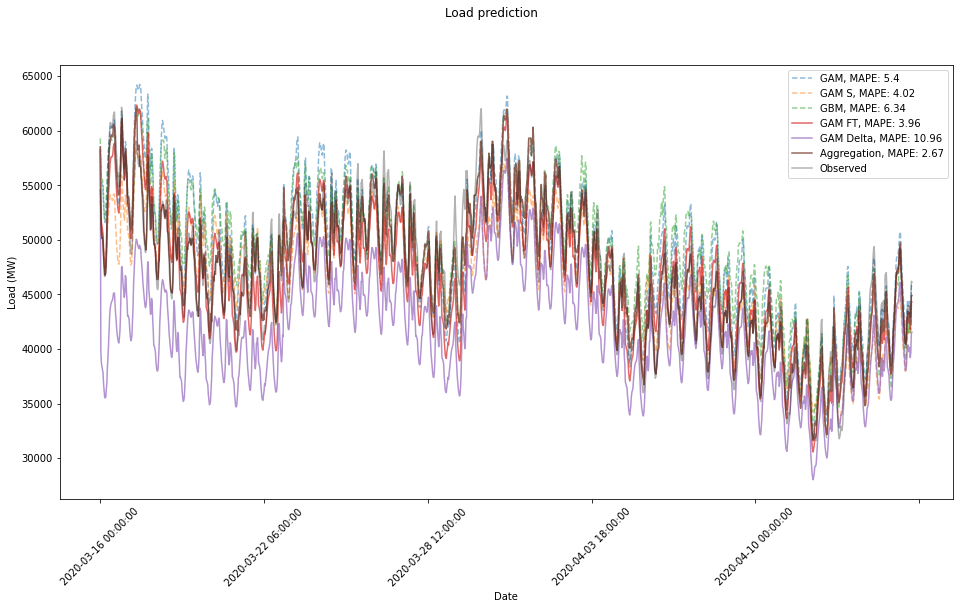

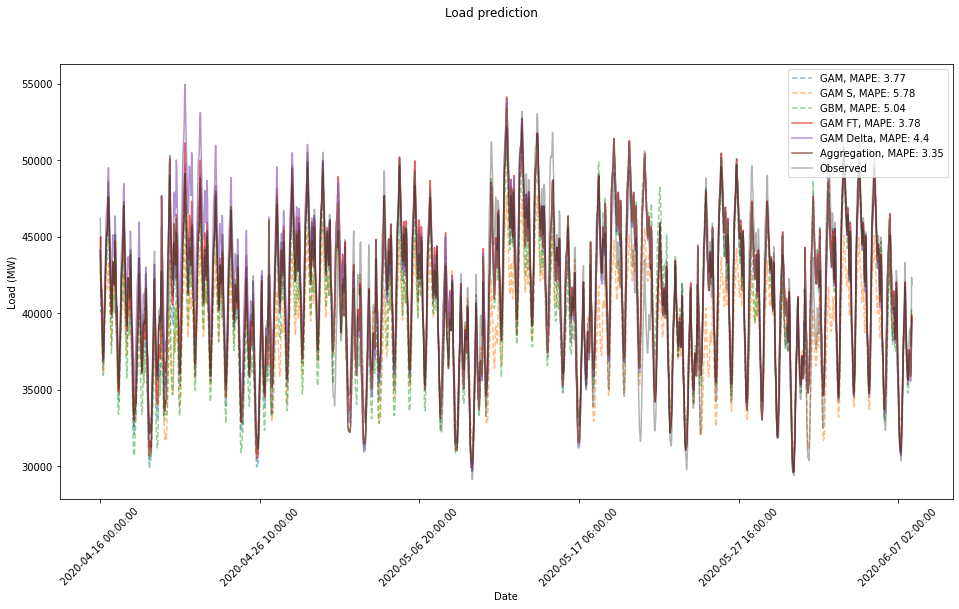

In [53]:
display_plots(type='test1')
display_plots(type='test2')

In [47]:
# Export the results to csv
ft_te1_v2_df = pd.DataFrame(ft_te1_v2, columns=['ft_te1_v2'])
ft_te1_v2_df.to_csv('data/experts/ft_te1_v2.csv', index=False)

ft_te2_v2_df = pd.DataFrame(ft_te2_v2, columns=['ft_te2_v2'])
ft_te2_v2_df.to_csv('data/experts/ft_te2_v2.csv', index=False)

delta1_v2_df = pd.DataFrame(delta1_v2, columns=['delta1_v2'])
delta1_v2_df.to_csv('data/experts/delta1_v2.csv', index=False)

delta2_v2_df = pd.DataFrame(delta2_v2, columns=['delta2_v2'])
delta2_v2_df.to_csv('data/experts/delta2_v2.csv', index=False)

# ft_delta1_df = pd.DataFrame(ft_delta1, columns=['ft_delta1'])
# ft_delta1_df.to_csv('data/experts/ft_delta1.csv', index=False)
# ft_delta2_df = pd.DataFrame(ft_delta2, columns=['ft_delta2'])
# ft_delta2_df.to_csv('data/experts/ft_delta2.csv', index=False)